<a href="https://colab.research.google.com/github/SankulR/Comparing-ML-approaches-for-Cardinality-Estimation/blob/master/Top2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import numpy as np
#read the csv file with tweets
df=pd.read_csv('totalTweets_fullData.csv',error_bad_lines=False,encoding='latin-1')
df['tweets'] = df['tweets'].astype(str) 
df.head(6)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


twittername          accountname  ...    masked_user_id user_type
0  10minnovelist  10 Minute Novelists  ...  depressed_user_1         1
1  10minnovelist  10 Minute Novelists  ...  depressed_user_1         1
2  10minnovelist  10 Minute Novelists  ...  depressed_user_1         1
3  10minnovelist  10 Minute Novelists  ...  depressed_user_1         1
4  10minnovelist  10 Minute Novelists  ...  depressed_user_1         1
5  10minnovelist  10 Minute Novelists  ...  depressed_user_1         1

[6 rows x 10 columns]

In [ ]:
import re
import string
import nltk
from gensim import corpora, models, similarities 
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [ ]:
!pip install preprocessor
!pip install stopwords
!pip install stop_words
!pip install emoji
!pip install contractions
!pip install pyspellchecker
!pip install empath

  Created wheel for preprocessor: filename=preprocessor-1.1.3-cp36-none-any.whl size=4477 sha256=0a743ed21143e0b7773e16c9cf21eb2ff559cdc386dd1545de5ceb055aca8c7b
  Stored in directory: /root/.cache/pip/wheels/98/c1/a2/21fbcfd80d76576bbf148991a66f00730f541f265c7600000f
Successfully built preprocessor
     |████████████████████████████████| 51kB 2.9MB/s 
  Created wheel for stopwords: filename=stopwords-0.1.3-py2.py3-none-any.whl size=37286 sha256=d5aa40ed6538629564e45bc2c2586497c44246328c585b81f29d247526a4707f
  Stored in directory: /root/.cache/pip/wheels/39/fa/c7/c4c5111e658f5c58465d948165dc3395a3c10ff57f4cd20356
Successfully built stopwords
  Created wheel for stop-words: filename=stop_words-2018.7.23-cp36-none-any.whl size=32916 sha256=ef99a1e547781f6cc8943d5e38802727584a0feb9e3037cf16c266f4a9cd75c5
  Stored in directory: /root/.cache/pip/wheels/75/37/6a/2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words
     |████████████████████████████████| 51kB 2.8M

In [ ]:
import tweepy
from tweepy import Stream
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener

import re #regular expression
import string
import preprocessor as p
from stop_words import get_stop_words
import nltk
from nltk.corpus import stopwords,wordnet
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer,PorterStemmer
import emoji
from spellchecker import SpellChecker
import contractions


from empath import Empath
lexicon = Empath()
spell = SpellChecker()


class AntonymReplacer(object):
    def replace(self, word, pos=None):
        antonyms = set()
        for syn in wordnet.synsets(word, pos=pos):
            for lemma in syn.lemmas():
                for antonym in lemma.antonyms():
                    antonyms.add(antonym.name())
        if len(antonyms) == 1:
            return antonyms.pop()
        else:
            return None
        
        
    def replace_negations(self, sent):
        i, l = 0, len(sent)
        words = []
        while i < l:
            word = sent[i]
            if word == 'not' and i+1 < l:
                ant = self.replace(sent[i+1])
                if ant:
                    words.append(ant)
                    i += 2
                    continue
            words.append(word)
            i += 1
        return words


replacer = AntonymReplacer()


def connect_Twitter(prop):
    
    
    
    auth = tweepy.OAuthHandler(prop['TwitterCredentials']['consumer_key'], prop['TwitterCredentials']['consumer_secret'])
    auth.set_access_token(prop['TwitterCredentials']['access_key'], prop['TwitterCredentials']['access_secret'])
    api = tweepy.API(auth)
    
    
    return api



#HappyEmoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])
    
    
# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])
    
    
    
emoticons = emoticons_happy.union(emoticons_sad)


#Emoji patterns
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)
    
    
    
def tweet_clean_tp(rawData):

    rawData = p.clean(rawData)
    
    return rawData

def tweet_parse_tp(text):
    
    parse_df = p.parse(text)
    
    return parse_df
    
def extract_emojis(s):
    return ''.join(c for c in s if c in emoji.UNICODE_EMOJI)

def retrieve_hashtags(tweet):
    
    hashtags = [i  for i in tweet.split() if i.startswith("#") ]
    return hashtags

def retrieve_mentions(tweet):
    mentions = re.findall(r"@([a-zA-Z0-9]{1,15})", tweet)
    return mentions

def retrieve_urls(tweet):
    urls = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', tweet)
    
    return urls

def retrieve_emotions(text):
    full_emotions = lexicon.analyze(text, normalize=True)

    actual_emotions = {}
    for k, v in full_emotions.items():
        if v>0:
            actual_emotions[k] = v

    return actual_emotions


def stopword_removal(tweet):

    stop_words = list(get_stop_words('en'))         
    nltk_stopwords = list(stopwords.words('english'))   
    stop_words.extend(nltk_stopwords)
    stop_words = list(set(stop_words))

    
    #after tweepy preprocessing the colon symbol left remain after      #removing mentions
    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'‚Ä¶', '', tweet)
    
    
    #replace consecutive non-ASCII characters with a space
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)
    
    #remove emojis from tweet
    tweet = emoji_pattern.sub(r'', tweet)

    word_tokens = word_tokenize(tweet)
    
    #filter using NLTK library append it to a string
#    filtered_tweet = [w for w in word_tokens if not w in stop_words]
    filtered_tweet = []
    
    # looping through conditions
    for w in word_tokens:
        #check tokens against stop words , emoticons and punctuations
        if w not in stop_words and w not in emoticons and w not in string.punctuation:
            filtered_tweet.append(w)

    filtered_tweet = (" ".join(filtered_tweet))
    return filtered_tweet
    
def pos_tags(tweet):
    
    tweet_tokens = word_tokenize(tweet)
    
    tagged = nltk.pos_tag(tweet_tokens)
    
#    print(tagged)
    verbs_list = []
    nouns_list = []
    adjectives_list = []
    adverbs_list = []
    
    for i in range(len(tagged)):
        if tagged[i][1] == 'JJ' or tagged[i][1] == 'JJR' or tagged[i][1] == 'JJS':
            adjectives_list.append(tagged[i][0])
#    for i in range(len(tagged)):
        elif tagged[i][1] == 'RB' or tagged[i][1] == 'RBR' or tagged[i][1] == 'RBS':
            adverbs_list.append(tagged[i][0])
#    for i in range(len(tagged)):
        elif tagged[i][1] == 'NN' or tagged[i][1] == 'NNS' or tagged[i][1] == 'NNP' or tagged[i][1] == 'NNPS':
            nouns_list.append(tagged[i][0])
#    for i in range(len(tagged)):
        elif tagged[i][1] == 'VB' or tagged[i][1] == 'VBD' or tagged[i][1] == 'VBG' or tagged[i][1] == 'VBN' or tagged[i][1] == 'VBP' or tagged[i][1] == 'VBZ':
            verbs_list.append(tagged[i][0])
    
    
    pos_tag_list = verbs_list + nouns_list + adjectives_list + adverbs_list
    
#    print(pos_tag_list)
    pos_tag_list = (" ".join(pos_tag_list))

    return pos_tag_list



def lemmatise(tweet):
    
    tweet_tokens = word_tokenize(tweet)
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatised_tweet = [wordnet_lemmatizer.lemmatize(x) for x in tweet_tokens]

    lemmatised_tweet = (" ".join(lemmatised_tweet))
    return lemmatised_tweet


def porter_stemming(tweet):
    
    tweet_tokens = word_tokenize(tweet)
    ps= PorterStemmer()
    
    stemmed_tweet = [ps.stem(x) for x in tweet_tokens]

    stemmed_tweet = (" ".join(stemmed_tweet))
    return stemmed_tweet


def spell_check(tweet):
    correct_word = []
    mispelled_word = tweet.split()
    for word in mispelled_word:
        correct_word.append(spell.correction(word))
        
    return ' '.join(correct_word)

def fix_contractions(tweet):
    

    fixed_tweet = contractions.fix(tweet)
    
    return fixed_tweet


def replace_negations_antonyms(tweet):
    
    tweet_tokens = word_tokenize(tweet)

    replaced_tweet = replacer.replace_negations(tweet_tokens)
    
    replaced_tweet = (" ".join(replaced_tweet))
    return replaced_tweet

In [ ]:
import time   
t1 = time.time()   
df['tweets'] = df['tweets'].apply(stopword_removal).astype(str)    
t2 = time.time()  
print("Time to clean and tokenize", len(df), "tweets:", (t2-t1)/60, "min")
df.head(5)

Time to clean and tokenize 113993 tweets: 0.8551016251246134 min


twittername          accountname  ...    masked_user_id user_type
0  10minnovelist  10 Minute Novelists  ...  depressed_user_1         1
1  10minnovelist  10 Minute Novelists  ...  depressed_user_1         1
2  10minnovelist  10 Minute Novelists  ...  depressed_user_1         1
3  10minnovelist  10 Minute Novelists  ...  depressed_user_1         1
4  10minnovelist  10 Minute Novelists  ...  depressed_user_1         1

[5 rows x 10 columns]

In [ ]:
def preprocess(tweets):
    tweets = tweets.replace("(<br/>)", "")
    tweets = tweets.replace('(<a).*(>).*(</a>)', '')
    tweets = tweets.replace('(&amp)', '')
    tweets = tweets.replace('(&gt)', '')
    tweets = tweets.replace('(&lt)', '')
    tweets = tweets.replace('(\xa0)', ' ')
    tweets = tweets.replace("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))", " ")
    tweets = tweets.replace('(http[s]?(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+)', ' ')
    tweets = tweets.replace('(RT)', ' ')
    tweets = tweets.replace('([a-zA-Z0-9]{1,15})', '  ')
    tweets = tweets.replace('(\n)', '  ')
    return tweets

In [ ]:

df['tweet'] = df['tweet'].apply(preprocess).astype(str)

KeyError: ignored

In [ ]:
import re
df['tweet'] = df['tweets'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
df.head()

twittername  ...                                              tweet
0  10minnovelist  ...  Seven More Ways To Ship Your Characters https/...
1  10minnovelist  ...  Putting Author Happiness day thread https//t.c...
2  10minnovelist  ...  Seven More Ways To Ship Your Characters https/...
3  10minnovelist  ...  Every Wednesday 10MinuteNovelists everywhere c...
4  10minnovelist  ...  Homeschooling exhausting Year 18 day two https...

[5 rows x 11 columns]

In [ ]:
!pip install numba==0.51.2
!python -m pip install umap
!pip install 'umap-learn==0.3.10'
!pip install top2vec

     |████████████████████████████████| 3.1MB 5.6MB/s 
     |████████████████████████████████| 24.6MB 1.4MB/s 
  Found existing installation: llvmlite 0.31.0
    Uninstalling llvmlite-0.31.0:
      Successfully uninstalled llvmlite-0.31.0
  Found existing installation: numba 0.48.0
    Uninstalling numba-0.48.0:
      Successfully uninstalled numba-0.48.0
  Created wheel for umap: filename=umap-0.1.1-cp36-none-any.whl size=3566 sha256=0a06c5f91ceaaa40491cdf187a9ea231d44efa1a5df08608db4f9d92a0f6694a
  Stored in directory: /root/.cache/pip/wheels/7b/29/33/b4d917dc95f69c0a060e2ab012d95e15db9ed4cc0b94ccac26
Successfully built umap
     |████████████████████████████████| 40kB 3.2MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.3.10-cp36-none-any.whl size=38882 sha256=9c166c6766bc5554f81f6aef744d547ef9bf3bce716f4387f3a16a89abdc8376
  Stored in directory: /root/.cache/pip/wheels/d0/f8/d5/8e3af3ee957feb9b403a060ebe72f7561887fef9dea658326e
Successfully built umap-learn
  Found existi

In [ ]:
from top2vec import Top2Vec

In [ ]:
lis = df['tweet'].astype(str).values.tolist()

In [ ]:
model = Top2Vec(documents=lis, speed="learn", workers=16)

2020-11-28 15:36:23,459 - top2vec - INFO - Pre-processing documents for training
2020-11-28 15:36:27,557 - top2vec - INFO - Creating joint document/word embedding
2020-11-28 17:13:09,456 - top2vec - INFO - Creating lower dimension embedding of documents
/usr/local/lib/python3.6/dist-packages/numba/core/typed_passes.py:314: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../usr/local/lib/python3.6/dist-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components
2020-11-28 17:18:29,307 - top2vec - INFO - Finding dense areas

In [ ]:
topic_sizes, topic_nums = model.get_topic_sizes()

In [ ]:
topic_nums

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [ ]:
topic_words, word_scores, topic_nums = model.get_topics(793)

In [ ]:
topic_words

array([['kujeu', 'taps', 'shes_my_twin', ..., 'hik', 'exaarmy',
        'srbachchan'],
       ['jungleb', 'dogs', 'brianstelter', ..., 'seriously', 'maymay',
        'wo'],
       ['ang', 'ako', 'hindi', ..., 'kayo', 'kay', 'siya'],
       ...,
       ['vq', 'uim', 'ou', ..., 'named', 'main', 'summer'],
       ['ifb', 'chesty', 'wherever', ..., 'asked', 'tips', 'hitchariide'],
       ['section', 'armys', 'yt', ..., 'mutuals', 'mass', 'si']],
      dtype='<U15')

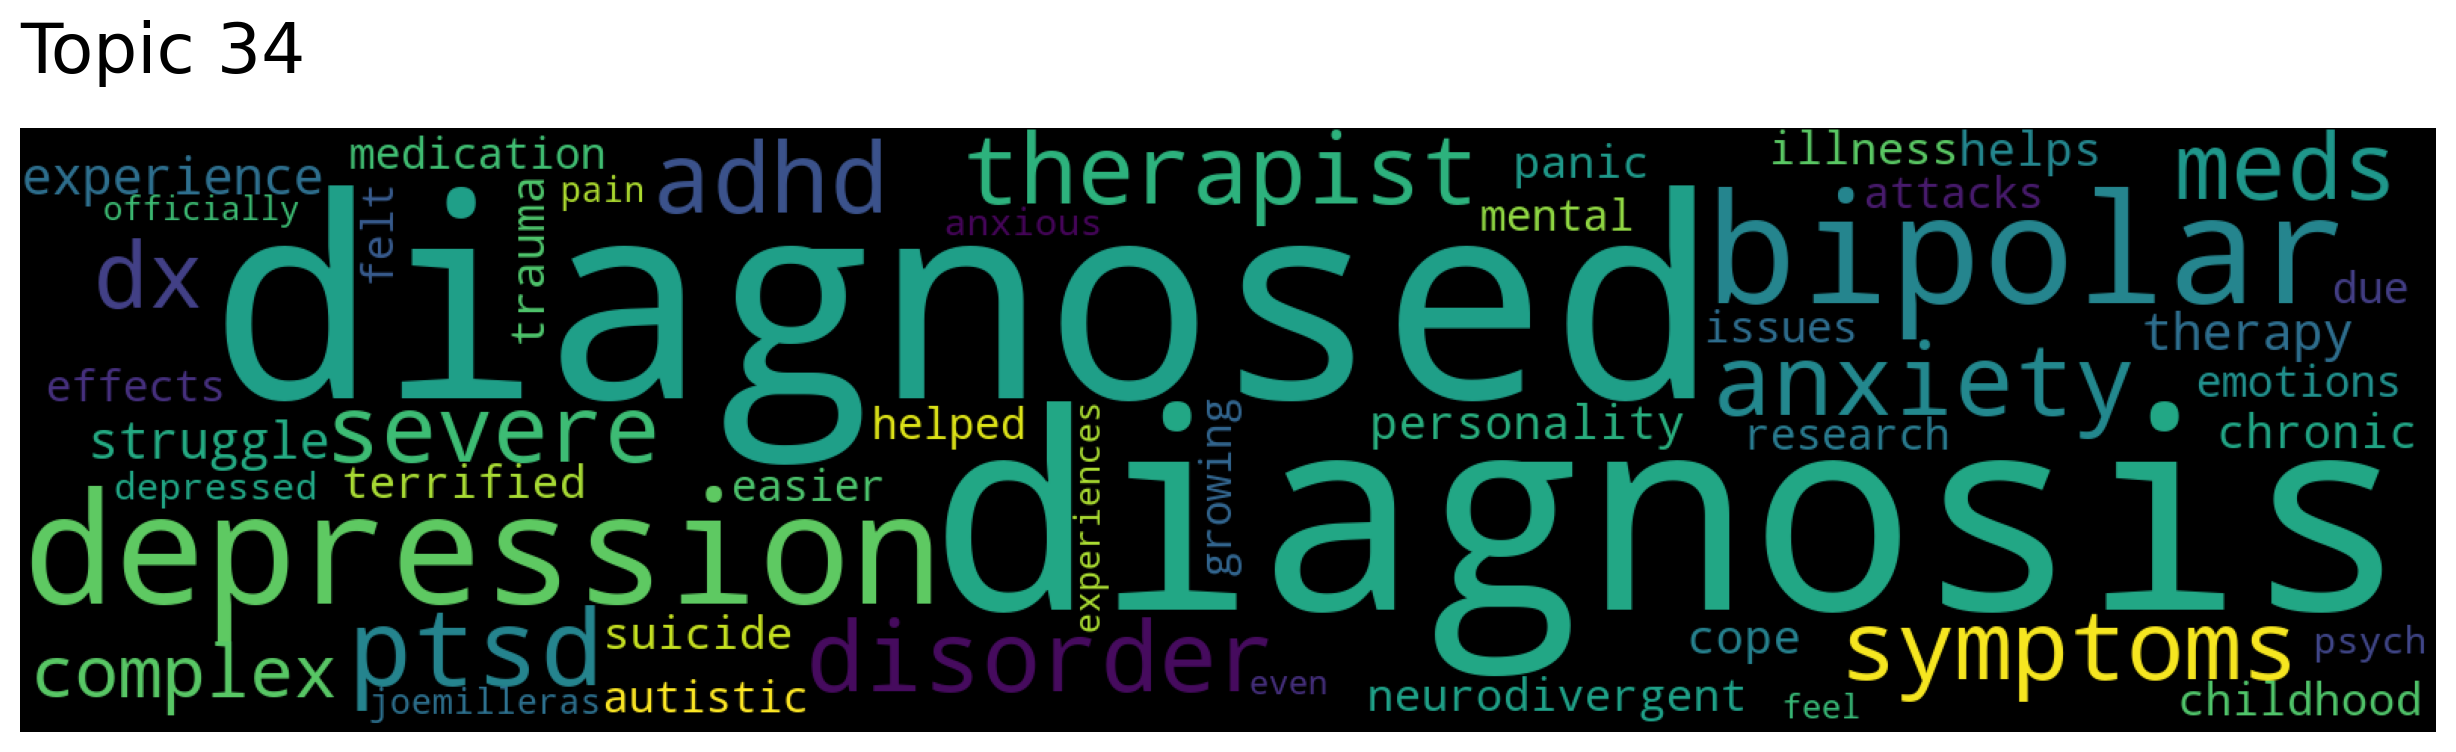

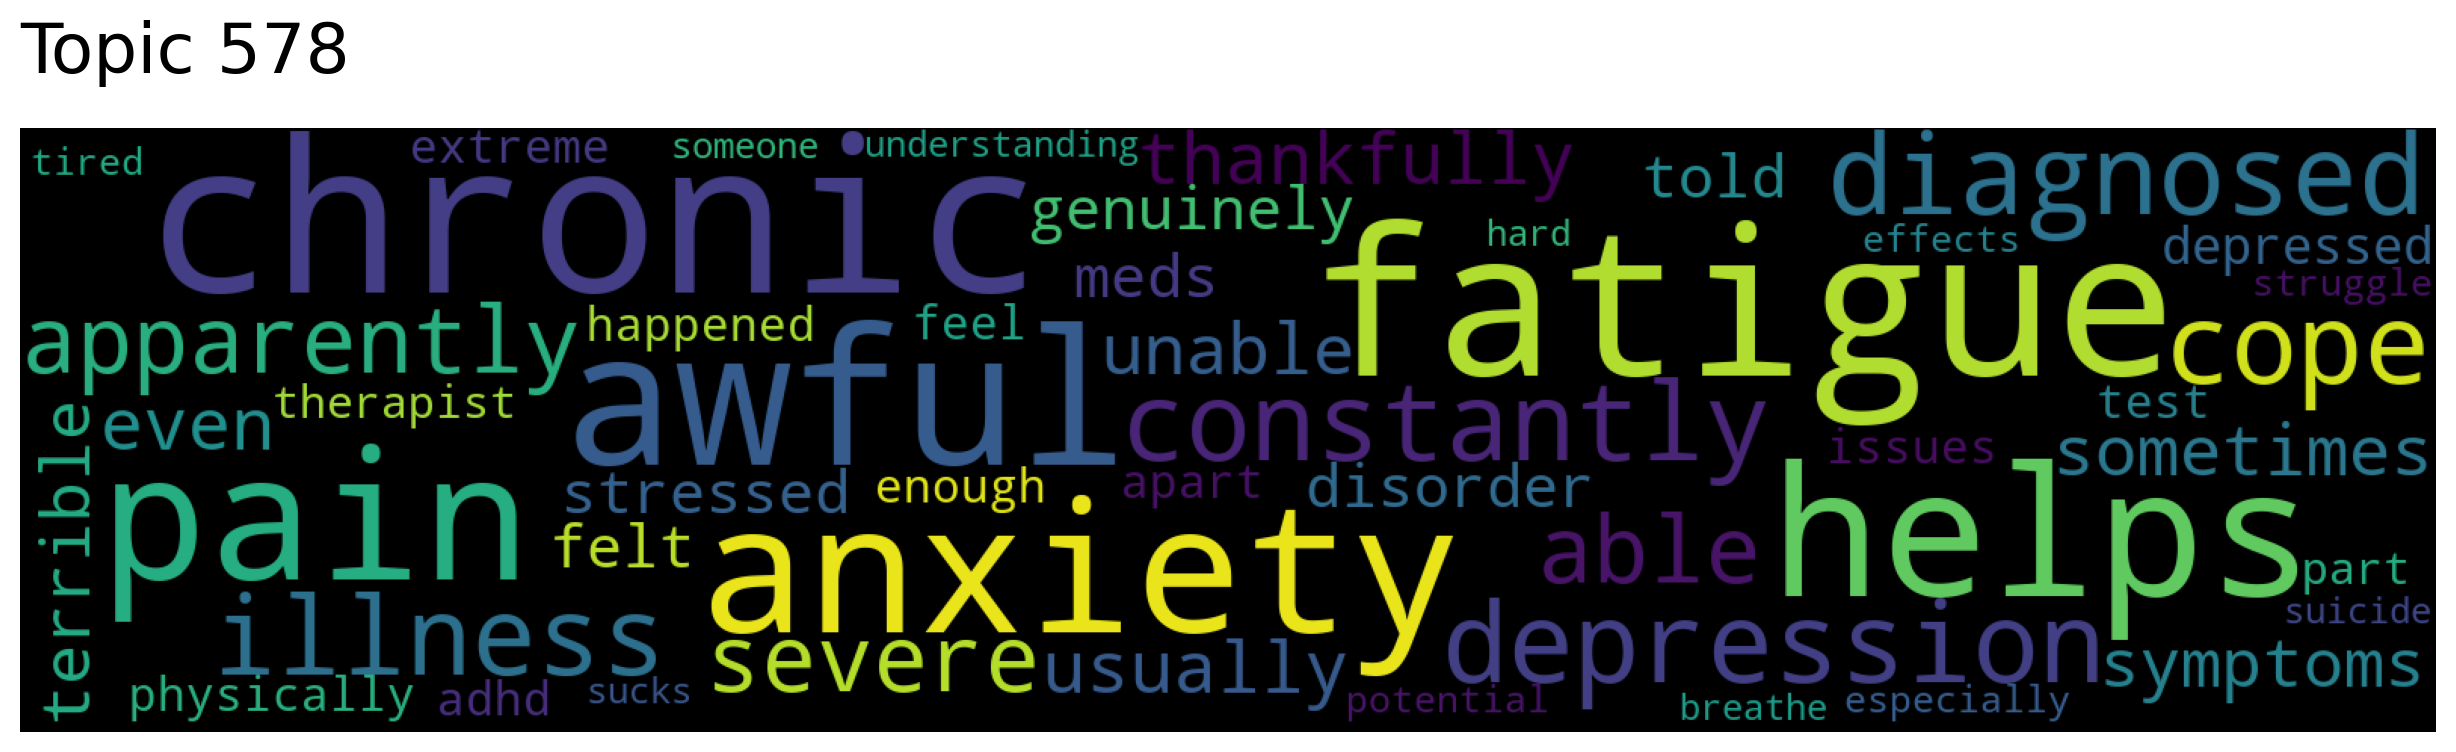

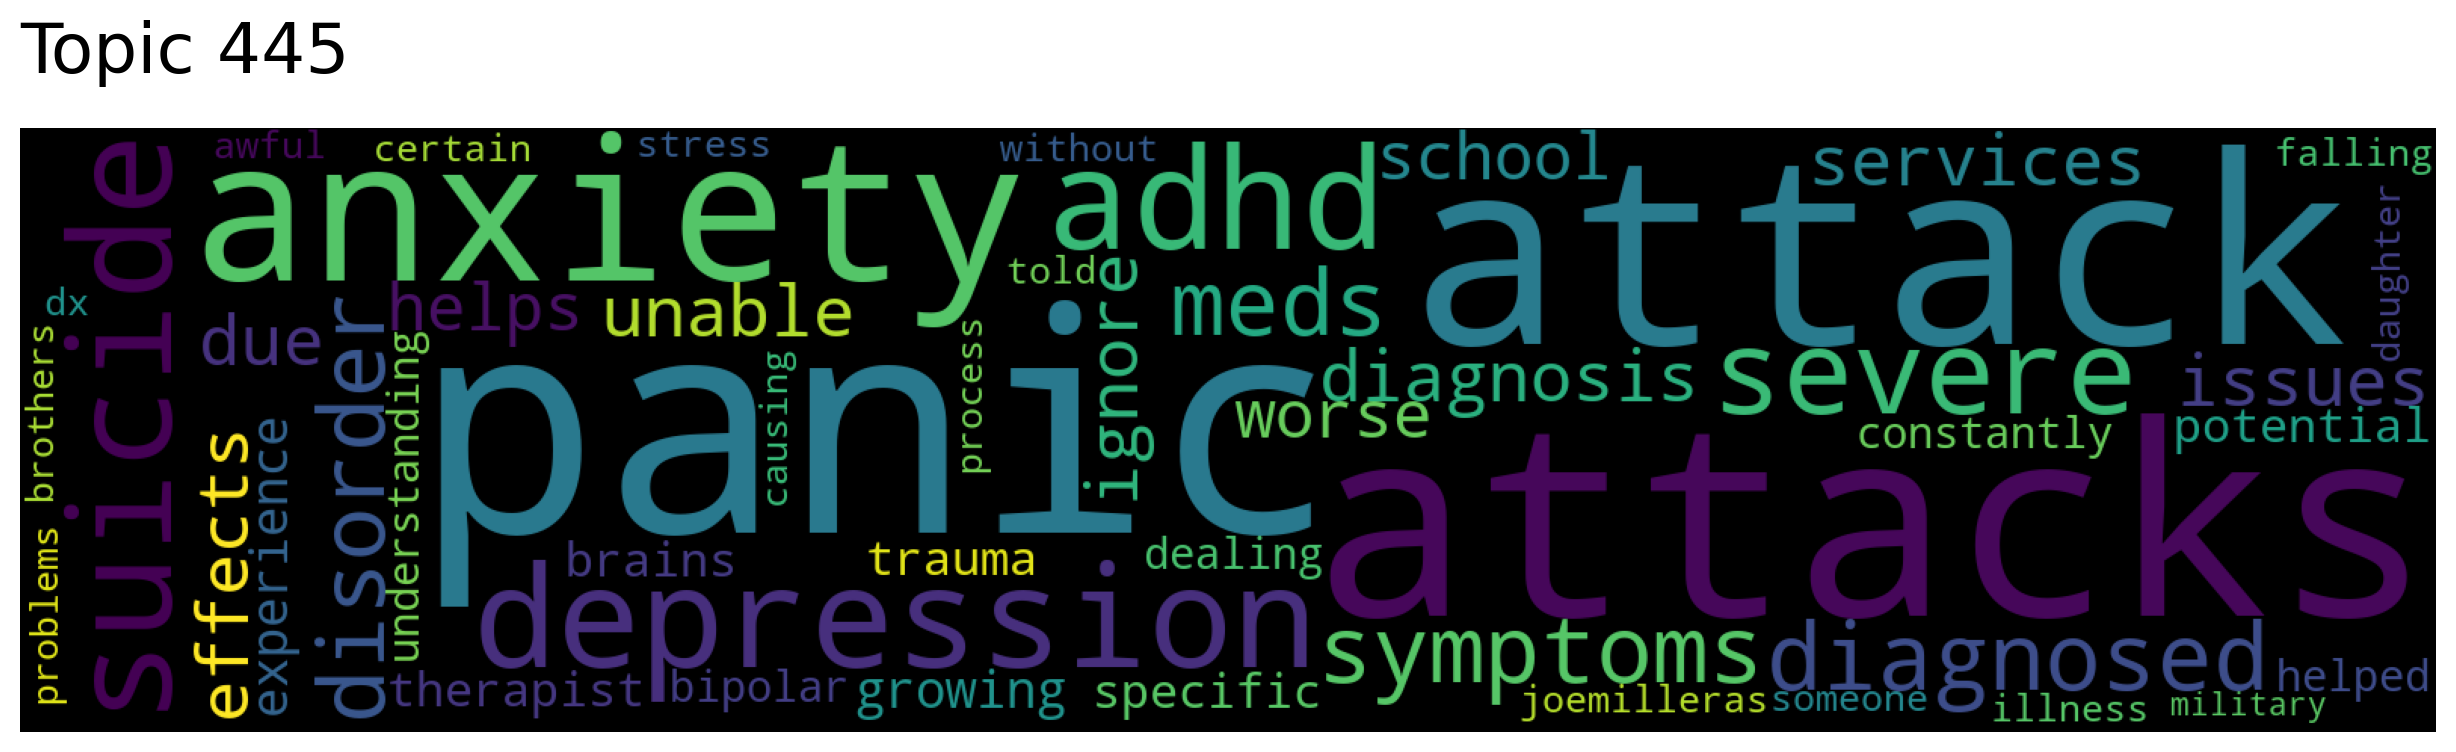

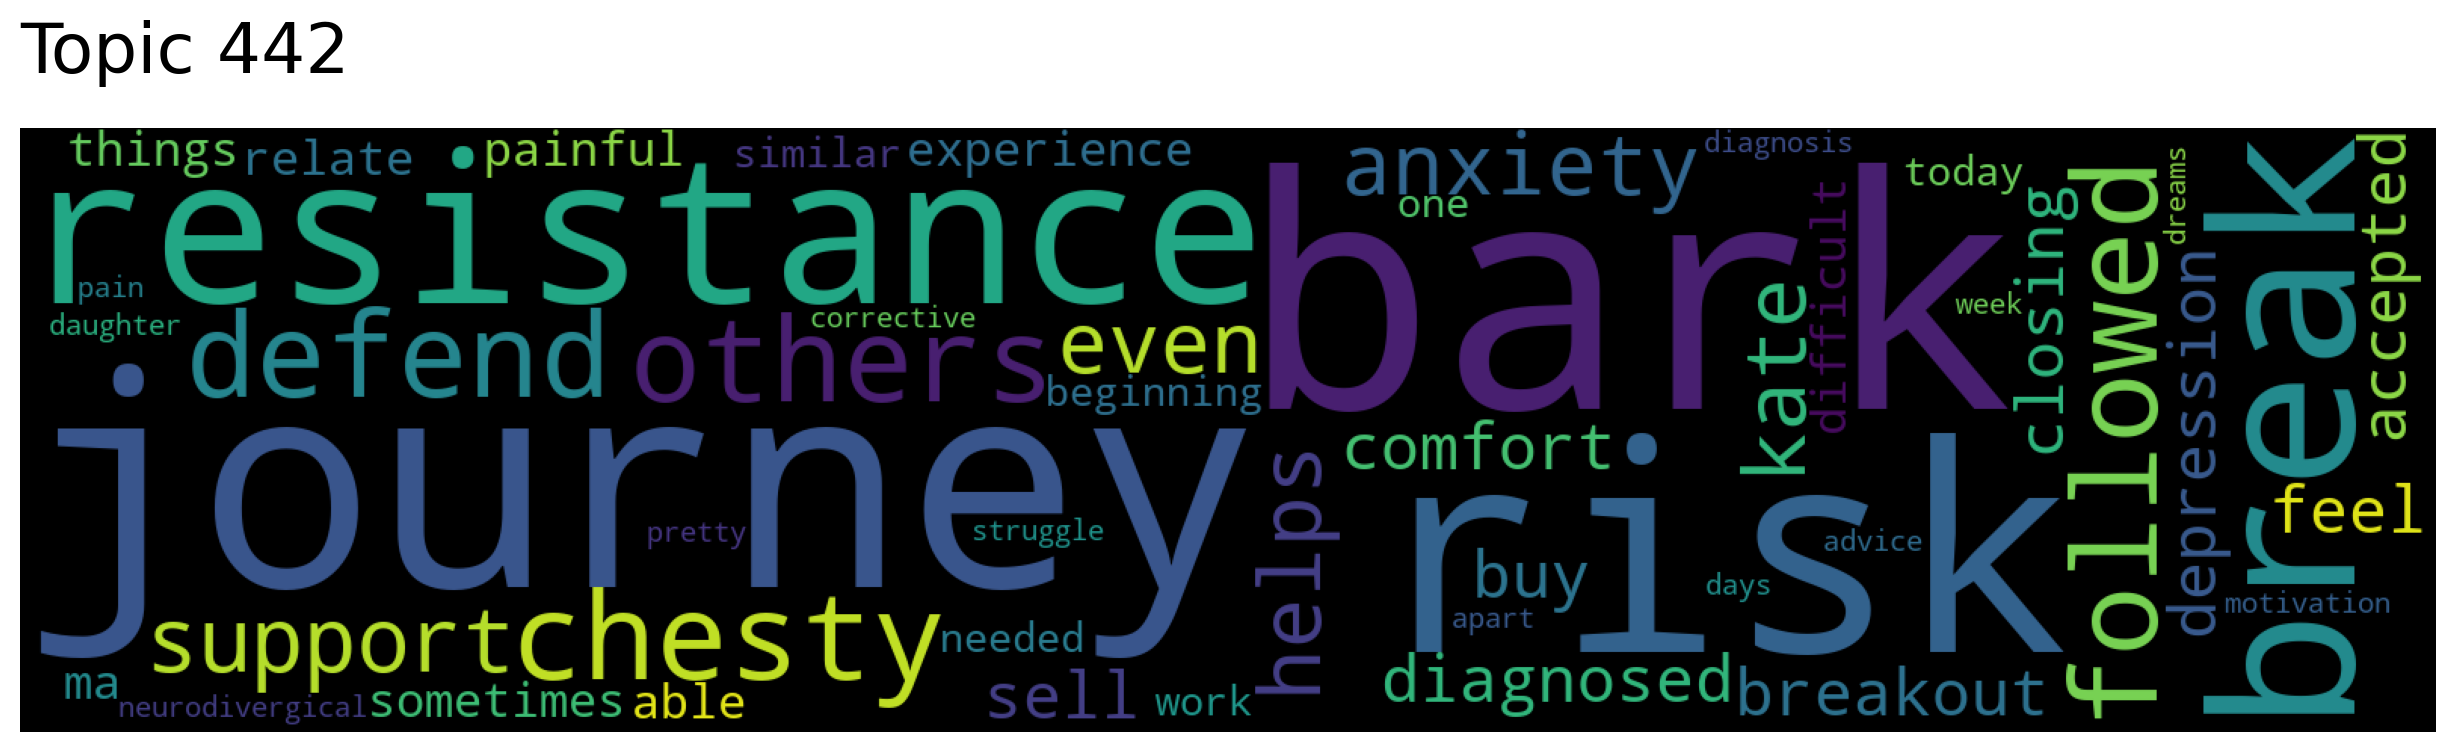

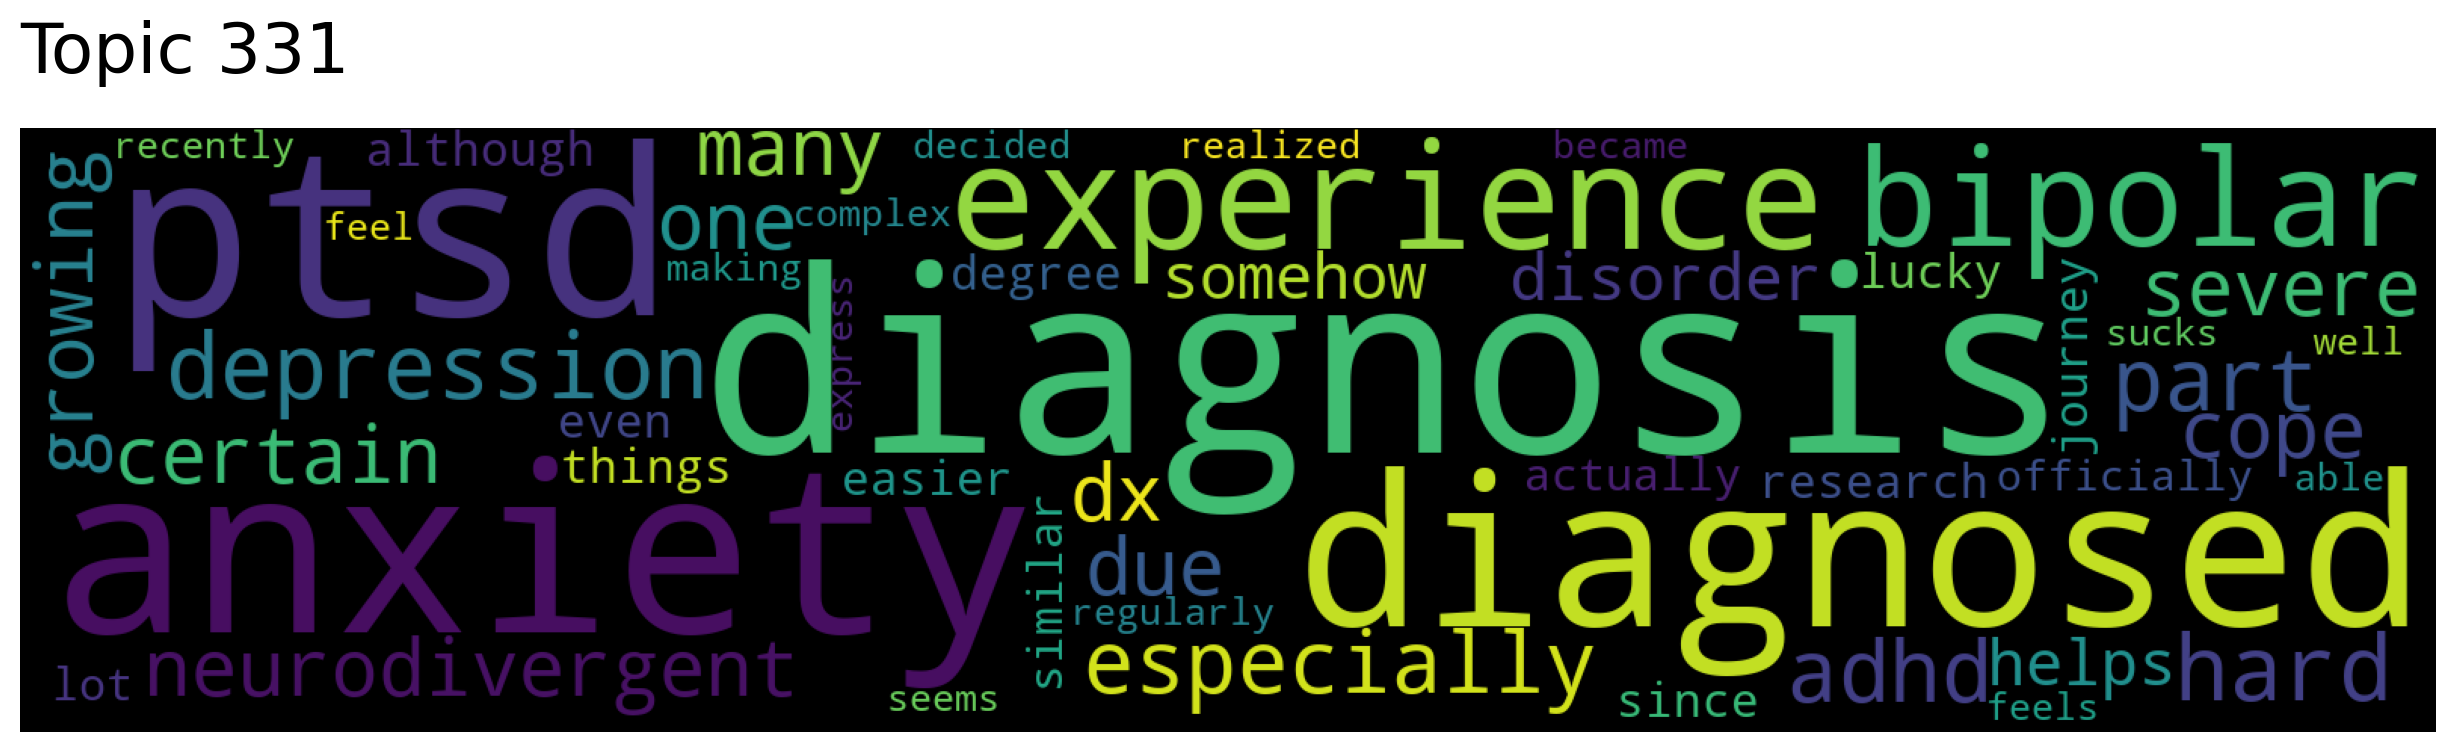

In [ ]:
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=["struggle"], num_topics=5)
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

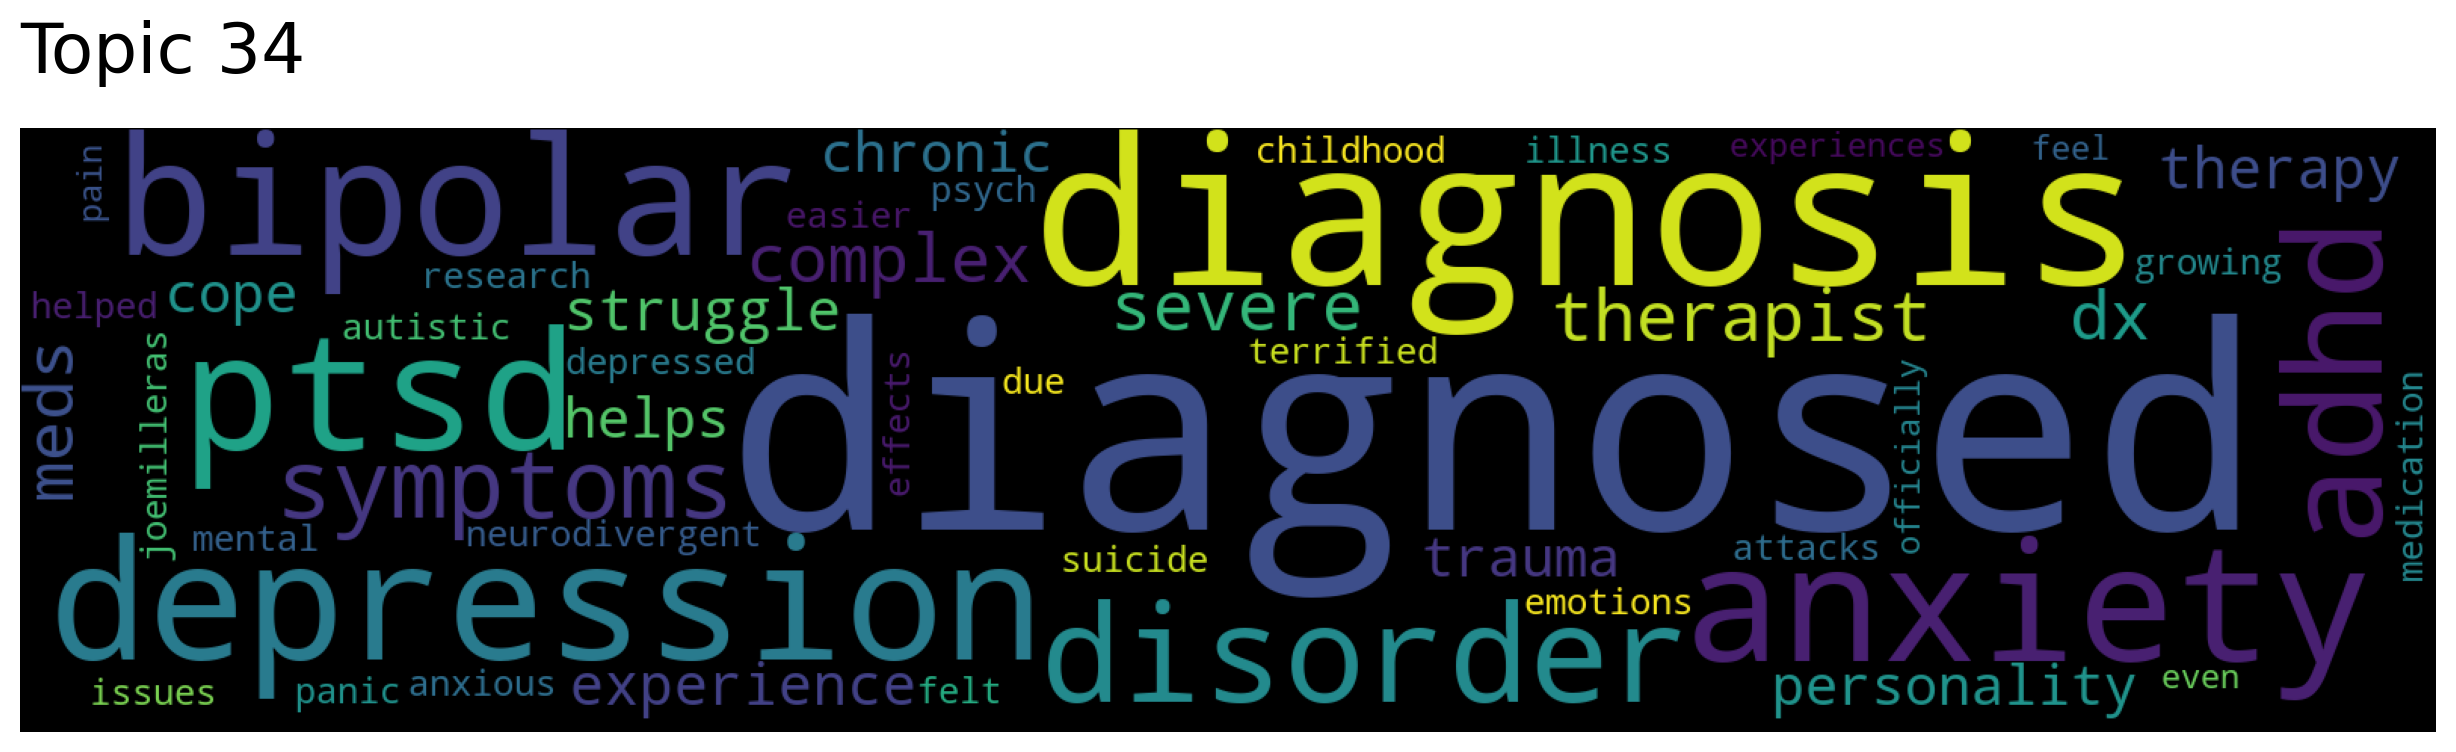

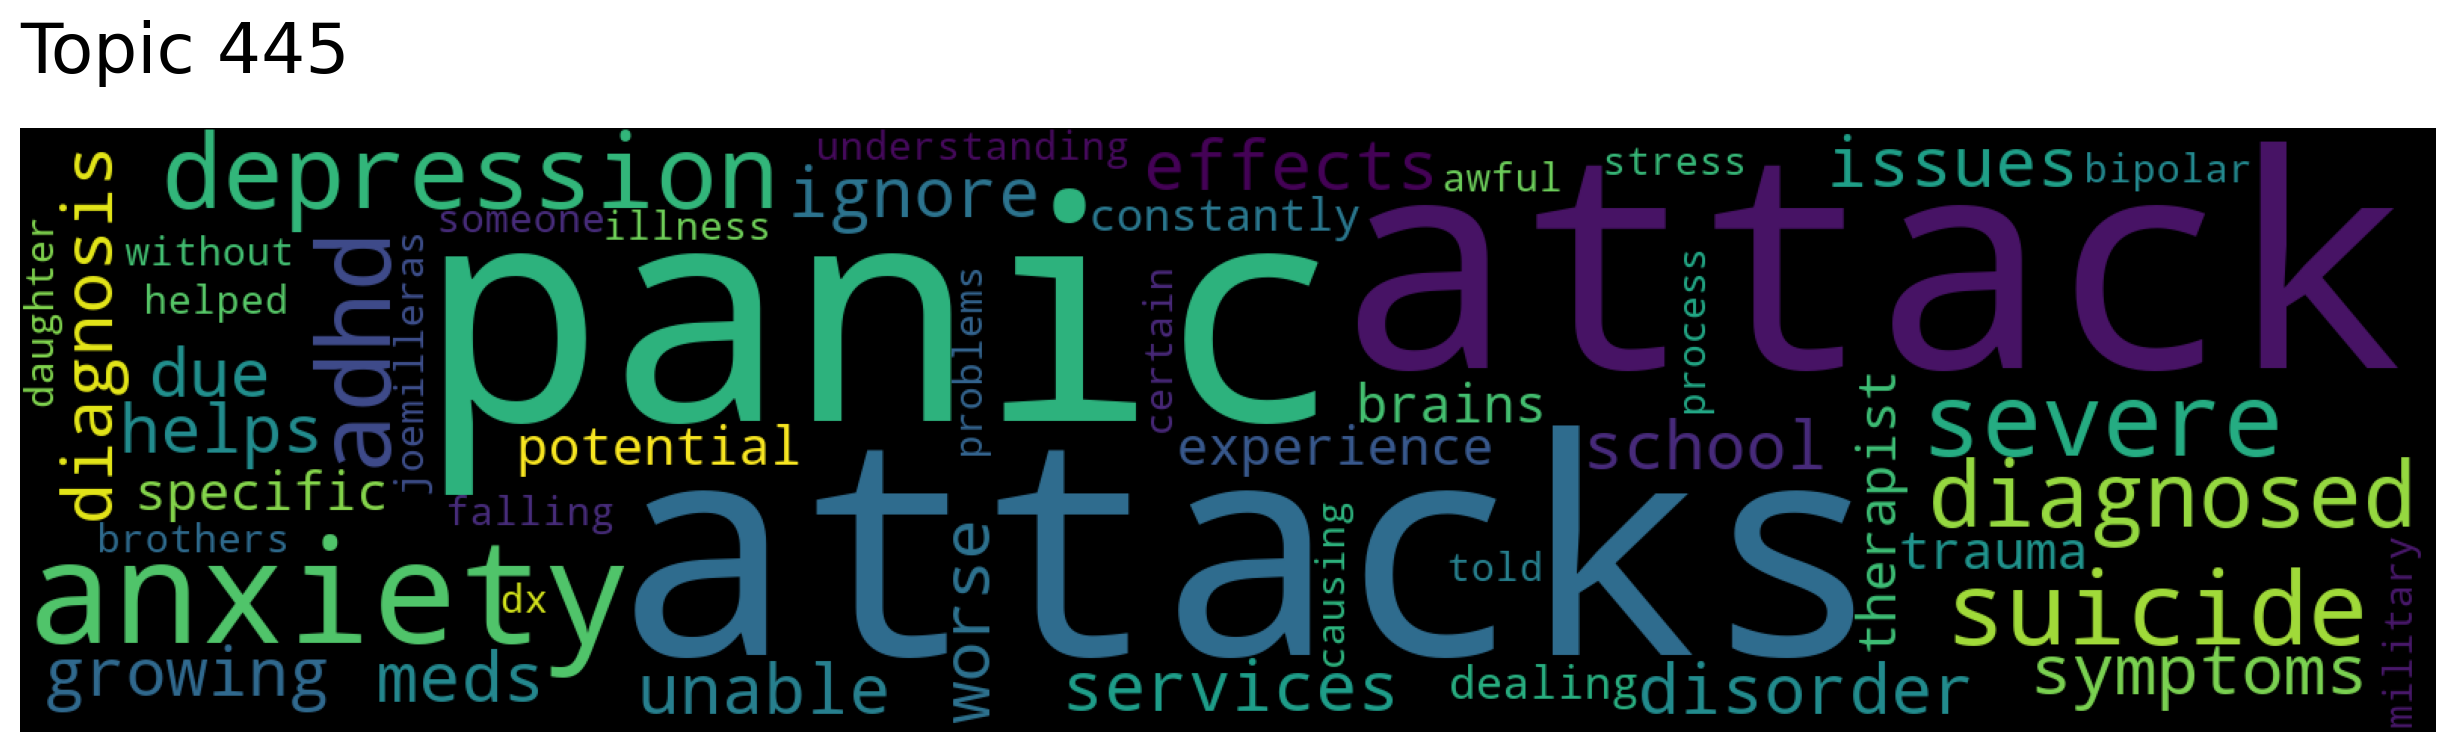

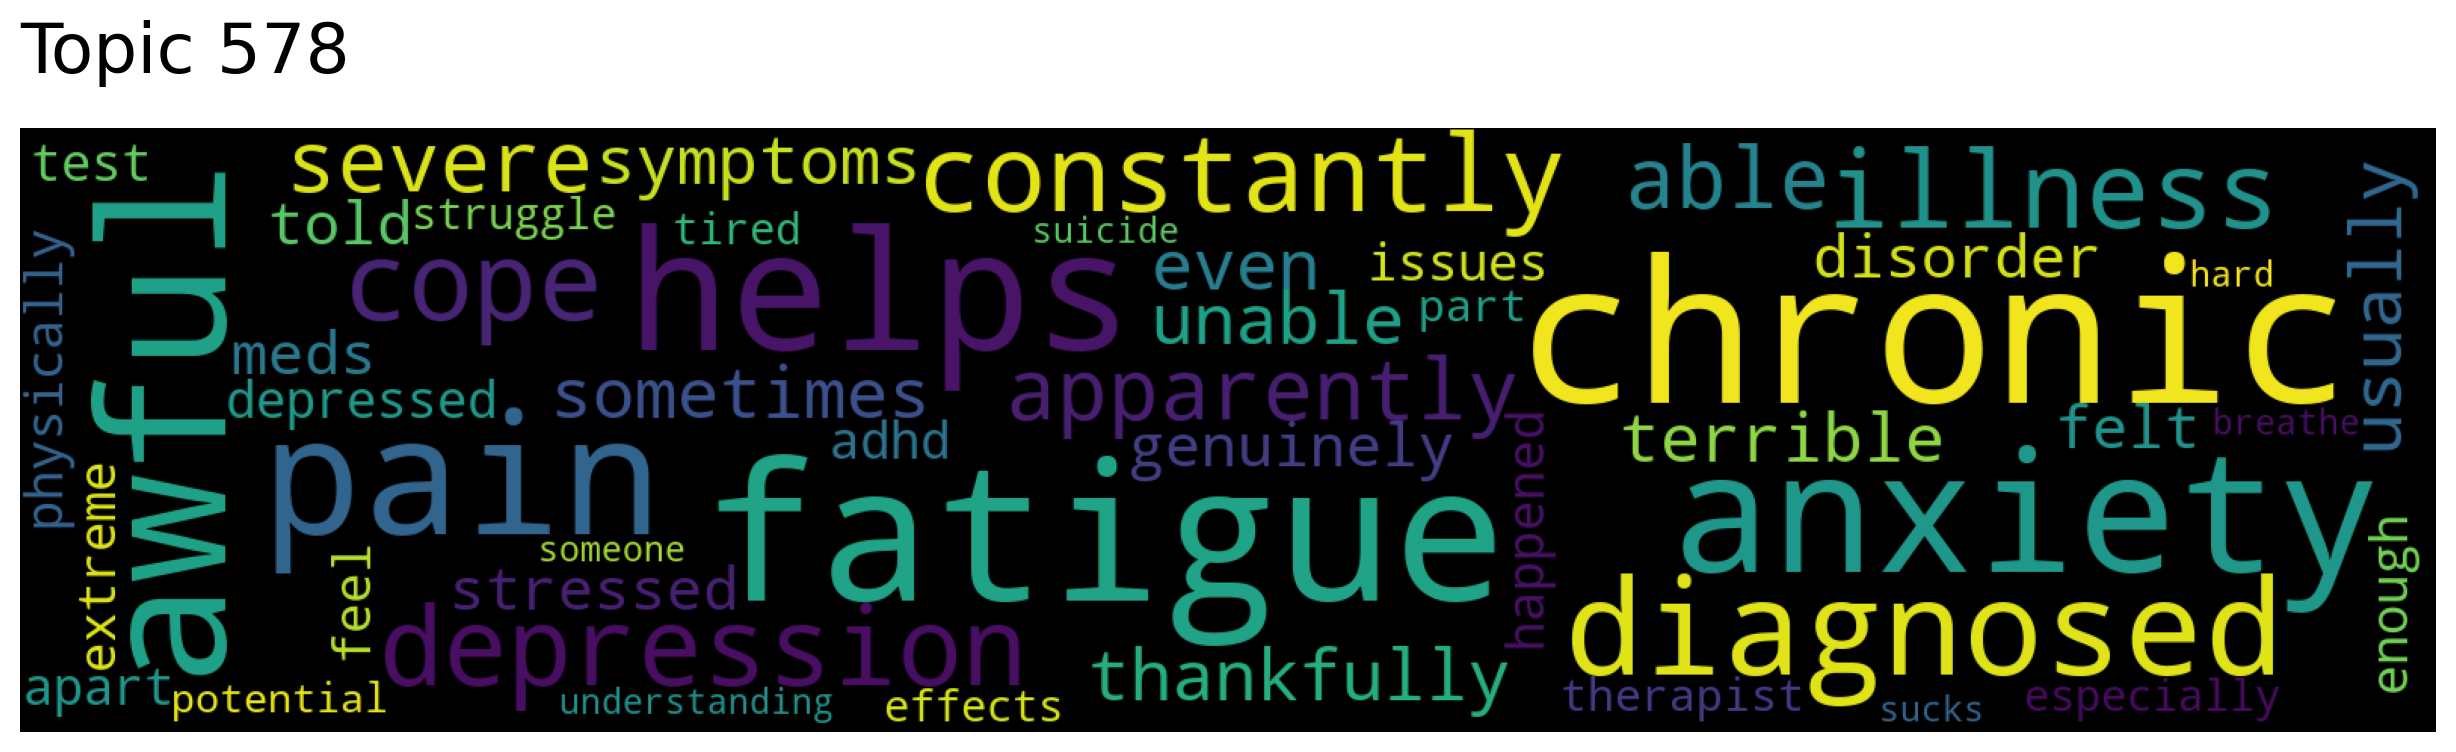

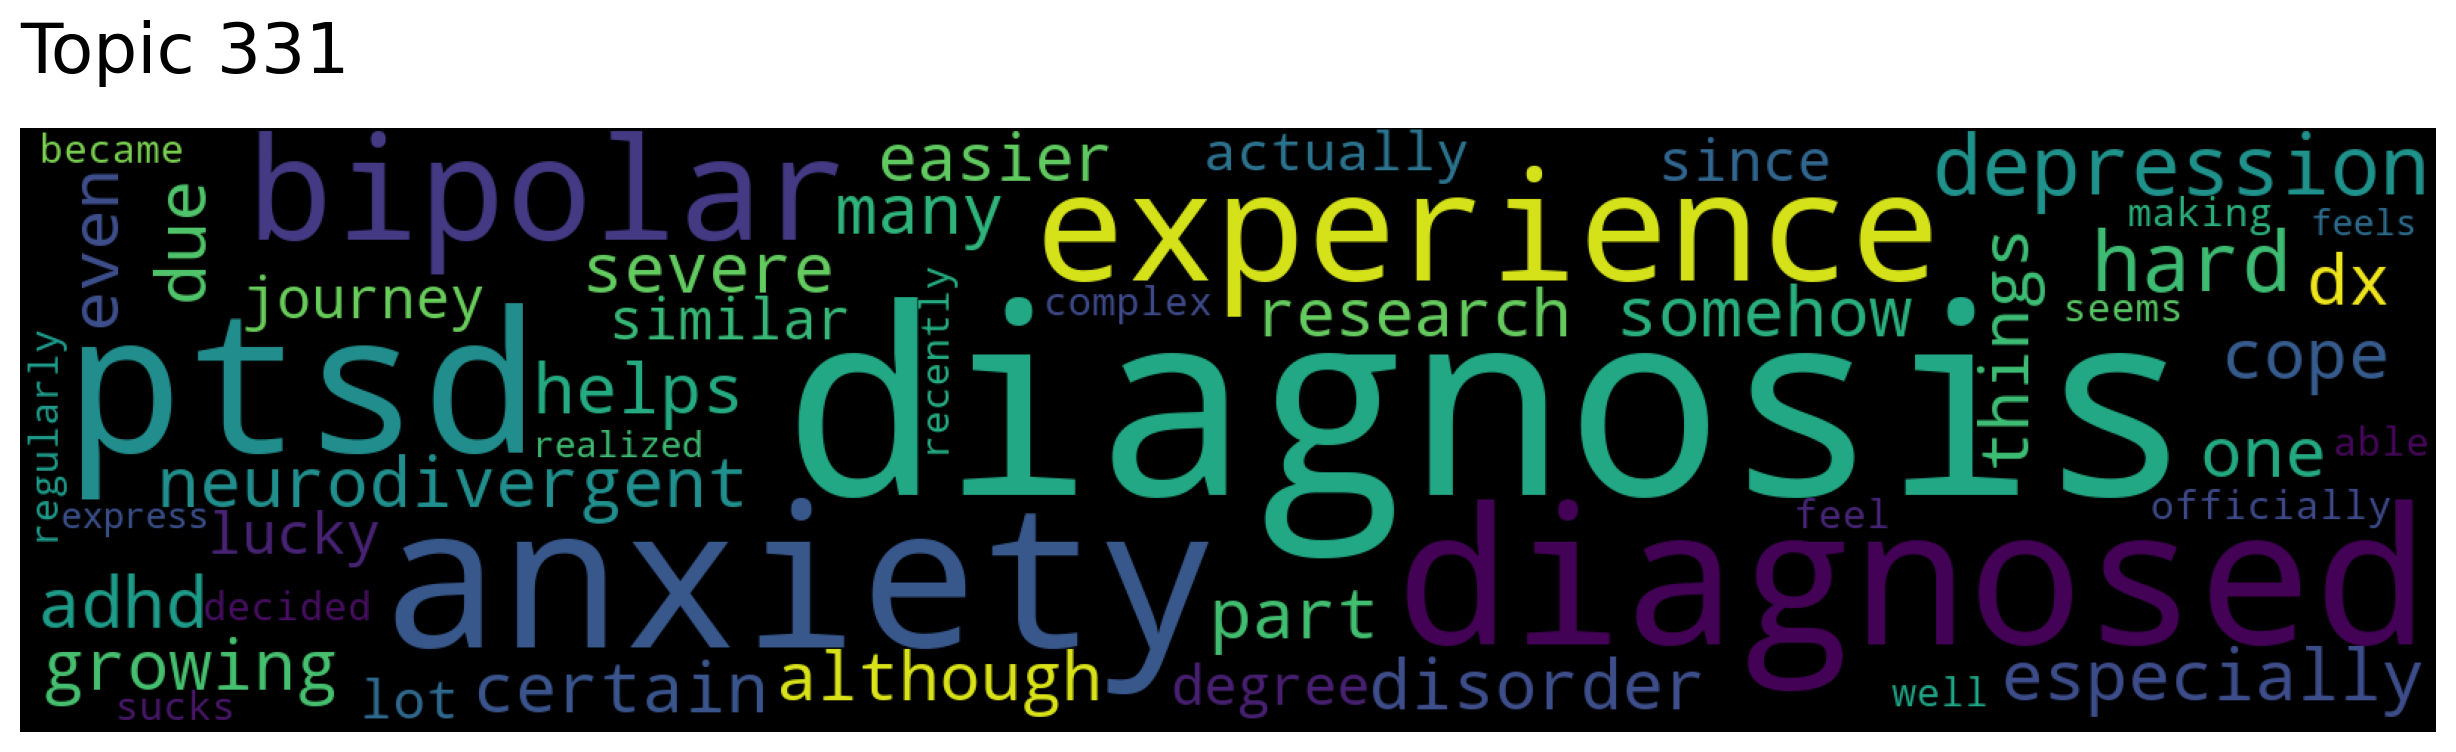

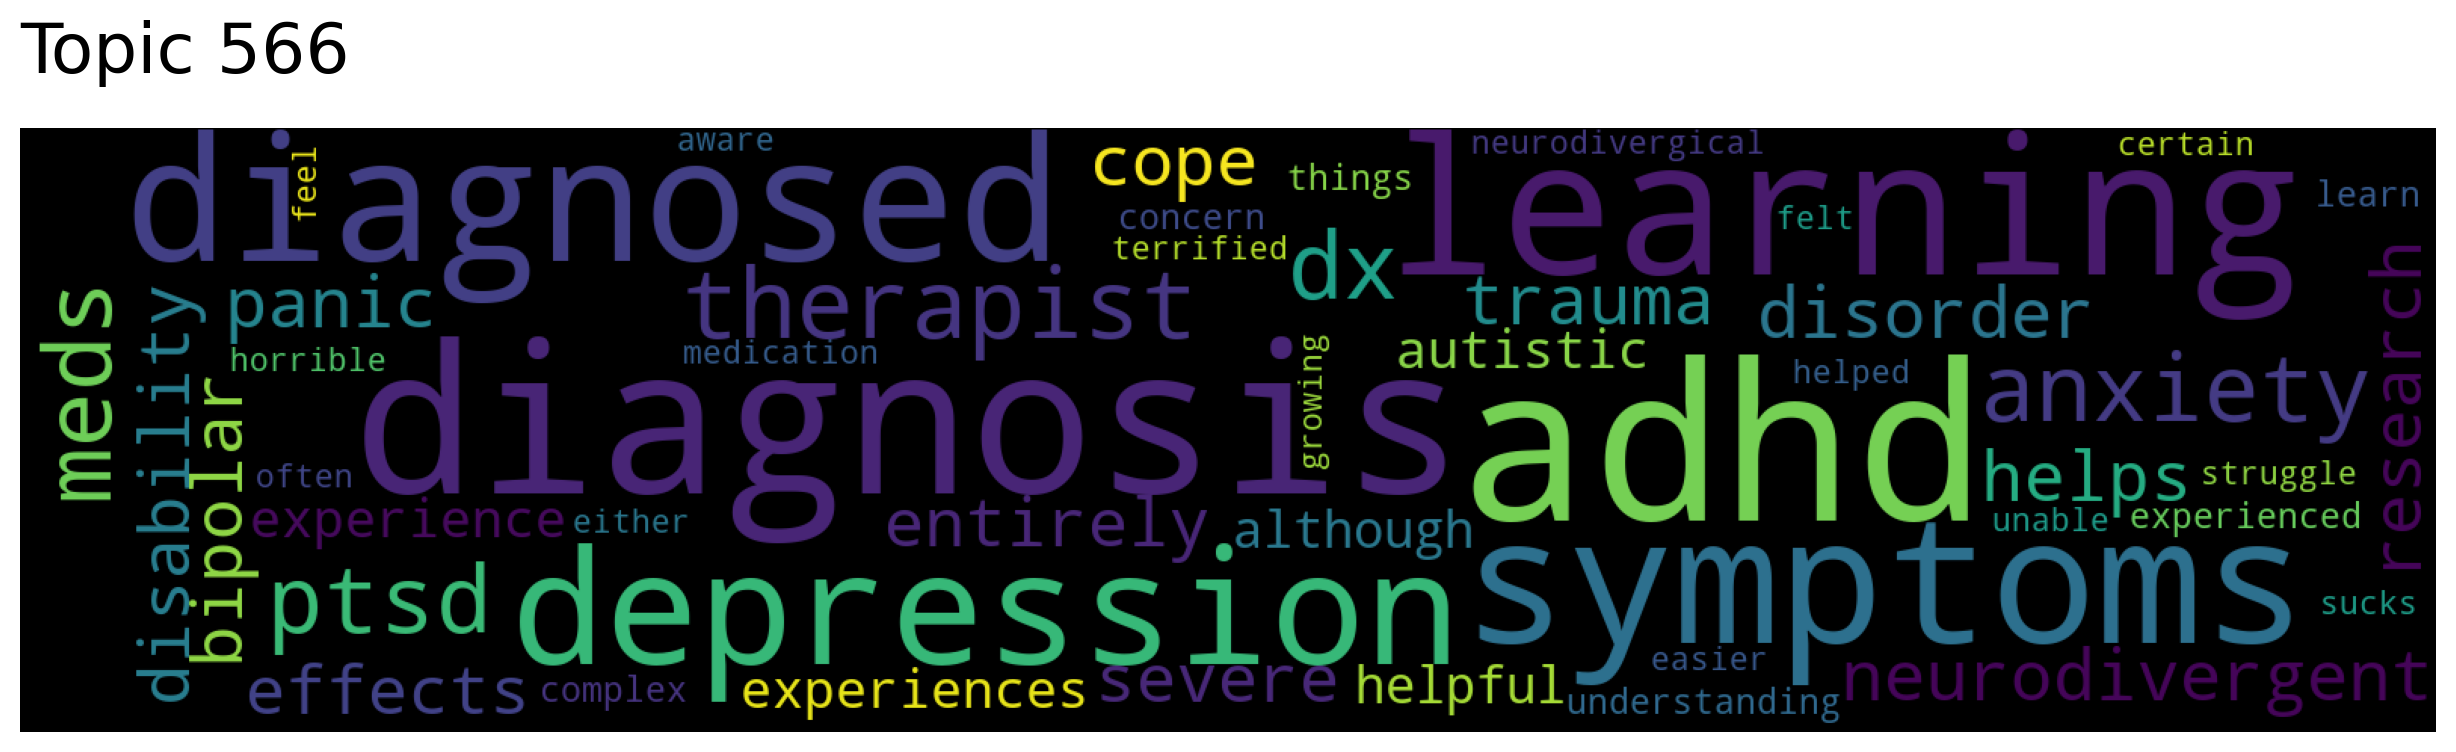

In [ ]:
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=["depression"], num_topics=5)
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

In [ ]:
model.save("Top2Vec model")

In [ ]:
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=207, num_docs=10)

In [ ]:
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=207, num_docs=10)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print("-----------")
    print()

Document: 52817, Score: 0.9174922704696655
-----------
I hate having bipolar disorder, bad anxiety and depression.
-----------

Document: 58262, Score: 0.8871155977249146
-----------
@phillisnicole I was diagnosed with bipolar depression &amp; ptsd when I was 18. I get it , girl !
-----------

Document: 43256, Score: 0.8615408539772034
-----------
@iamveryquirky @computerbath @WhereisGloboi I've been clinically diagnosed with depression, schizotypal personality disorder, and ptsd :)
-----------

Document: 17890, Score: 0.8452208638191223
-----------
@Frattgirl But she was told over and over it was #mentalhealth, all in her head, anxiety, depression, even a hidden eating disorder.
-----------

Document: 33816, Score: 0.8410560488700867
-----------
That all might actually change now. My therapist strongly suspects that I've been misdiagnosed, &amp; thats why meds are rejecting and making some aspects worse. I was previously diagnosed with depression, anxiety, &amp; PTSD. But she thinks I

In [ ]:
words, word_scores = model.similar_words(keywords=["struggle"], keywords_neg=[], num_words=20)
for word, score in zip(words, word_scores):
    print(f"{word} {score}")

diagnosed 0.3705
anxiety 0.368
ptsd 0.3599
through 0.3522
others 0.3522
illness 0.3426
trauma 0.3402
myself 0.3289
disorder 0.3263
for 0.3101
became 0.3097
sometimes 0.3067
ur 0.3063
with 0.3007
my 0.3007
someone 0.3
giving 0.2995
help 0.2995
major 0.2992
start 0.2983


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
